Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for running CNN and optical flow models on the stream of data and determining classfication accuracy.

In [1]:
from data_extraction import get_video_data, FIRE_VIDEOS_DATA_PATH
import os

In [2]:
val_fire_videos, val_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "validation"))
test_fire_videos, test_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "test"))


In [3]:
import random
from video_model import VideoModel, VideoModelFromImageModel
from cnn import CNNFireDetector
from train_cnn import InferenceModel, TrainingModel, TRANSFORM

# Load models


# TODO: initialize your models here


class DummyModel(VideoModel):

    def predict_on_last_frame(self, frames):
        # random prob between 0 and 1
        return random.uniform(0, 1)



my_image_model : VideoModel = VideoModelFromImageModel(CNNFireDetector.load_from_file(InferenceModel(TrainingModel()), "test_model.pth"))
google_net : VideoModel = DummyModel()
alex_net : VideoModel = DummyModel()
optical_flow_model : VideoModel = DummyModel()

Number of parameters in the model: 111218


In [4]:
"""
I want each model to give me a list of predictiosn for each frame in the video , so the outputs should be a list of floats in the range [0,1] for each video..

On Validation videos:
    I want to then use this list of booleans to determine Recall (TP / (TP + FN)) over all videos (only have positives in fire videos). 
    and False Alarm Rate (FP / (FP + TN)) over all videos (only have negatives in no fire videos).

    I will then plot a recall vs false alarm rate graph for each model to determine the best threshold.


Then, on testing videos, i will rerun this analysis with the chosen threshold and get the actual Recall and False Alarm Rate for each model.

I will then print thiese out for emach model, and for each model show a video stream of each viedo with a "Fire" or "No Fire" 
text at teh top left of each frame
"""



'\nI want each model to give me a list of predictiosn for each frame in the video , so the outputs should be a list of floats in the range [0,1] for each video..\n\nOn Validation videos:\n    I want to then use this list of booleans to determine Recall (TP / (TP + FN)) over all videos (only have positives in fire videos). \n    and False Alarm Rate (FP / (FP + TN)) over all videos (only have negatives in no fire videos).\n\n    I will then plot a recall vs false alarm rate graph for each model to determine the best threshold.\n\n\nThen, on testing videos, i will rerun this analysis with the chosen threshold and get the actual Recall and False Alarm Rate for each model.\n\nI will then print thiese out for emach model, and for each model show a video stream of each viedo with a "Fire" or "No Fire" \ntext at teh top left of each frame\n'

In [5]:
from prediction import get_predictions, get_false_positive_rate, get_recall
CHOSEN_MODEL = my_image_model
# TODO: run all the below code for each model separately and compare results (make function)
val_fire_predictions = get_predictions(CHOSEN_MODEL, val_fire_videos)
val_no_fire_predictions = get_predictions(CHOSEN_MODEL, val_no_fire_videos)






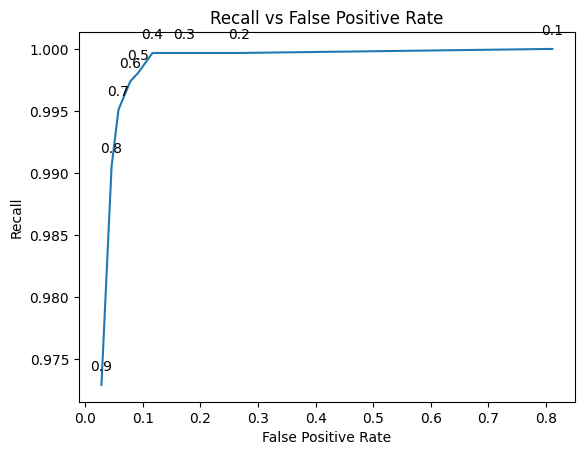

In [6]:
# use recall and FPR curve to determine best threshold for binarizing predictions
recalls = []
fprs = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # threshold above which a prediction probabiltiy is considered fire
for threshold in thresholds:
    recall = get_recall(val_fire_predictions, threshold)
    false_positive_rate = get_false_positive_rate(val_no_fire_predictions, threshold)
    recalls.append(recall)
    fprs.append(false_positive_rate)


# plot recall vs false positive rate
import matplotlib.pyplot as plt
plt.plot(fprs, recalls)

# add point lables with threshold
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (fprs[i], recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall vs False Positive Rate')
plt.show()

In [9]:
best_threshold = 0.7 # TODO:  manually choose the best threshold based on the plot


# get results on test videos
test_fire_predictions = get_predictions(my_image_model, test_fire_videos)
test_no_fire_predictions = get_predictions(my_image_model, test_no_fire_videos)
test_recall = get_recall(test_fire_predictions, best_threshold)
test_fpr = get_false_positive_rate(test_no_fire_predictions, best_threshold)
print("Test Recall: ", test_recall)
print("Test False Positive Rate: ", test_fpr)

Test Recall:  0.9951076320939335
Test False Positive Rate:  0.057799875699192045


In [12]:
import os
import cv2
import numpy as np

# Create output folder if it doesn't exist
os.makedirs("data", exist_ok=True)

def save_video(frames, predictions, filename, threshold=0.5, fps=30):
    h, w, _ = np.array(frames[0]).shape
    out_path = os.path.join("data", filename)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # use 'avc1' or 'XVID' if mp4v fails
    writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    for i, frame in enumerate(frames):
        # frame is in (C,H,W) format
        frame = frame.permute(1, 2, 0).numpy()  # convert (C, H, W) -> (H, W, C)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        text = "Fire" if predictions[i] >= threshold else "No Fire"
        color = (0, 0, 255) if text == "Fire" else (0, 255, 0)
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        writer.write(frame)

    writer.release()
    print(f"Saved: {out_path}")

# Save the first fire and no-fire videos
save_video(test_fire_videos[0], test_fire_predictions[0], "fire_video.mp4")
save_video(test_no_fire_videos[0], test_no_fire_predictions[0], "no_fire_video.mp4")



torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([3, 256, 400])
torch.Size([

/tmp/ipykernel_86517/3123062945.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h, w, _ = np.array(frames[0]).shape
